#### This shows how data can be prepared for the DAS month requirements, requiring 20m channel spacing and 100Hz. In this example, each 30sec file is first downsampled to keep memory reasonable, then stitched together into a single 1-hour HDF5 file.
#### Data is too large for github/gitlab; this is meant for illustrative purposes only

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta

#-- To import a function on a relative path:
import sys
sys.path.append("../")
from pydas_readers.readers import load_das_h5, write_das_h5
from pydas_readers.util import block_filters, block_cleaning

In [2]:
#-- Input Directory is raw data, full sample rate.
#-- Temp Directory is for downsampled data in 30-sec chunks (or whatever is default)
#-- Output Directory would be for combined 1-hour long H5 file.
input_dir = "/home/danielb/Documents/Datasets/Zugspitze2_example_day/"
temp_dir = "/home/danielb/Documents/Datasets/Zugspitze2_example_downsample/"
output_dir = "/home/danielb/Documents/Datasets/Zugspitze2_example_hour/"

#-- Define the time of an earthquake, and an end time +1 hour
eq_time = datetime.strptime('2022/03/25 00:18:10.0', '%Y/%m/%d %H:%M:%S.%f')
eq_end = eq_time + timedelta(hours=1)

#-- This dataset had initially 2m channel spacing. DAS Month wants ~20m channel spacing
nth_channel = 10

#-- This dataset had initially 500Hz sample rate. DAS Month wants 100Hz.
downsample_factor = 5

#-- Define the good channels to use [m]
d0 = 0
d1 = 2000  

#-- One option would be to load the entire hour, downsample, save. Easy!
#--  But: loading the entire hour will probably be too much memory for longer cables.
#--  So we'll define a function, below, and downsample each 30-sec file for now
#--  and combine only at the end

#data_raw, headers, axis = load_das_h5.load_das_custom(eq_time, eq_end, 
#                                                      d_start = d0, d_end = d1, 
#                                                      nth_channel = nth_channel,
#                                                      input_dir = input_dir, verbose=False)


In [3]:
def downsample_file(filename, input_dir, save_dir, nth_channel, downsample_factor, d0, d1, verbose=False):
    print("Downsampling: {0}".format(filename))
    headers_target = load_das_h5.load_headers_only(filename, verbose=verbose)

    # Attempt to load the new entire block length
    # -1sec at the front and +1sec at the end
    # start and end times are meant to exactly match the "load_headers" output
    target_t0 = headers_target['t0']
    target_t1 = headers_target['t1']
    data, headers, axis = load_das_h5.load_das_custom(target_t0 - timedelta(seconds=1),
                                                             target_t1 + timedelta(seconds=1),
                                                             input_dir=input_dir,
                                                             convert=False,
                                                             verbose=verbose,
                                                             d_start=d0, d_end=d1, nth_channel=nth_channel,
                                                             return_axis=True)
    # Here:
    #  - consider convert=True, to already correct to nano-strainrate.
    #     (the value in headers['amp_scaling'] will change so you can keep track of this later)
    #
    #    I don't convert here, however, because it could be more precise to do it later.
    #    The HDF5 data are saved at low precision. The less you touch the data before
    #    converting to float64, the better.
    #
    #  - Want to cut the start and end points? Use d_start=___ and d_end=___
    #
    #  - Want to also downsample spatially? The load function has a flag so you can pull 
    #      every n'th channel with indexing like [::n]. "nth_channel"
    #
    #
    # We add 1 second before and after, so that any filtering & tapering edge effects don't show in the actual data.
    # TODO: is +/- 1second enough? For DAS month earthquakes, possibly longer periods will be needed, so the buffer
    #  should correspond to 1 minimum period?

    # We will want to chop off that +/- 1 second later.
    #  but we don't necessarily KNOW that we could pull from the file before and after
    #  (i.e., for the first file in a directory, the previous file won't exist)
    # So instead we'll look at "date_times" to figure out the correct indices for output later
    # We know we want t0 to t1, because those were directly from the headers of the intended file.
    date_times = axis['date_times']
    i0_out = np.argmin(np.abs(np.array(date_times) - target_t0))
    i1_out = np.argmin(np.abs(np.array(date_times) - target_t1)) + 1
    # Added 1 to the index, because we want the final range [i0:i1] to be inclusive
    # and adding it here, specifically, so it's an even number for downsample division

    # In case we didn't load any time after, that +1 in the index is problematic
    if(i1_out > np.shape(data)[0]):
        i1_out = np.shape(data)[0]
        if(verbose):
            print("Warning: less data will return than was requested!")

    if(verbose):
        print("Pre downsample target {0} to {1}".format(i0_out,i1_out))

    # Adjust indices for the downsampling
    i0_out = int(i0_out/downsample_factor)
    i1_out = int(i1_out/downsample_factor)
    if(verbose):
        print("Postdownsample target {0} to {1}".format(i0_out,i1_out))

    # Downsample
    # (t1+1, to actually include that last index)
    fs = headers['fs']
    data2 = block_filters.chebychev_lowpass_downsamp(data,fs,downsample_factor,verbose=verbose)
    #
    # Note: the downsample function is based on how obspy does it.
    # We filter before decimating to avoid alisasing problems.
    #
    # The chebyshev type 2 filter ensures NO frequencies are left above the cutoff
    #  whereas the butterworth filter seismologists usually like only starts rolling off
    #  at that cutoff. This chebychev is much sharper, so if you're really interested in
    #  signals near the newly downsampled nyquist... change the filter or pick a higher nyquist.


    # Finally, cut off that +/- 1 sec if present
    data2 = data2[i0_out:i1_out]
    if(verbose):
        print("**** i0_out: {0}".format(i0_out))
        print("**** i1_out: {0}".format(i1_out))
        print(np.shape(data2))


    # Update headers
    headers['fs'] = fs/downsample_factor
    headers['fs_orig'] = fs
    headers['npts'] = np.shape(data2)[0]
    headers['t0']  = headers_target['t0']
    headers['t1']  = headers_target['t1']
    headers['dx']  = headers_target['dx']*nth_channel


    # See if the directory for this day exists, else create it
    day_dir = os.path.join(save_dir,headers_target['t0'].strftime('%Y_%m_%d'))
    if not os.path.exists(day_dir):
        os.makedirs(day_dir)

    new_filename = "{0}/downsampled_{1}.h5".format(day_dir, headers_target['t0'].strftime('%Y%m%d_%H%M%S.%f'))
    #print(new_filename)
    write_das_h5.write_block(data2,headers,new_filename)



In [4]:

consider_files = load_das_h5.make_file_list(eq_time, eq_end, input_dir)
print(consider_files)

for filename in consider_files:
    downsample_file(filename, input_dir, temp_dir, nth_channel, downsample_factor, d0, d1)

['/home/danielb/Documents/Datasets/Zugspitze2_example_day/day1_500Hz_2m_UTC_20220325_001706.855.h5', '/home/danielb/Documents/Datasets/Zugspitze2_example_day/day1_500Hz_2m_UTC_20220325_001736.855.h5', '/home/danielb/Documents/Datasets/Zugspitze2_example_day/day1_500Hz_2m_UTC_20220325_001806.855.h5', '/home/danielb/Documents/Datasets/Zugspitze2_example_day/day1_500Hz_2m_UTC_20220325_001836.855.h5', '/home/danielb/Documents/Datasets/Zugspitze2_example_day/day1_500Hz_2m_UTC_20220325_001906.855.h5', '/home/danielb/Documents/Datasets/Zugspitze2_example_day/day1_500Hz_2m_UTC_20220325_001936.855.h5', '/home/danielb/Documents/Datasets/Zugspitze2_example_day/day1_500Hz_2m_UTC_20220325_002006.855.h5', '/home/danielb/Documents/Datasets/Zugspitze2_example_day/day1_500Hz_2m_UTC_20220325_002036.855.h5', '/home/danielb/Documents/Datasets/Zugspitze2_example_day/day1_500Hz_2m_UTC_20220325_002106.855.h5', '/home/danielb/Documents/Datasets/Zugspitze2_example_day/day1_500Hz_2m_UTC_20220325_002136.855.h5',

In [5]:
data_downsampled, headers, axis = load_das_h5.load_das_custom(eq_time, eq_end, 
                                                      input_dir = temp_dir, verbose=False)
print(np.shape(data_downsampled))

new_filename = "{0}/earthquake_{1}.h5".format(output_dir, eq_time.strftime('%Y%m%d_%H%M%S.%f'))
write_das_h5.write_block(data_downsampled,headers,new_filename)

#-- Raw data from our Silixa/PRODML format is in Int16 format. Because we've processed the data, we now want to save as float32
#--  to avoid issues with dynamic range. This can be changed in "write_das_h5" (hardcoded for now). Saving in float32/float64 means
#--  that the size won't be as small as you might expect from frequency/space downsampling.

(360001, 99)


In [8]:
#-- Load that file just to check that it worked:
print(new_filename)
data, headers, axis = load_das_h5.load_file(new_filename)


/home/danielb/Documents/Datasets/Zugspitze2_example_hour//earthquake_20220325_001810.000000.h5


In [9]:
#-- Define a plotting function

#-- (Easier to define such a function in-notebook rather than in a loaded function, 
#--    since updating labels or colorbars is easier)

def waterfall_plot(data,headers, vmax=120):
    dx = headers['dx']
    fm = headers['fm']
    d0 = headers['d0']
    fs = headers['fs']

    plt.rcParams.update({'font.size': 14})

    plt.figure(figsize=(15,8))
    ax = plt.gca()

    plt.imshow(data.T, aspect="auto", cmap='seismic', interpolation='antialiased', 
            extent=(0,headers["npts"]/headers["fs"], headers["d1"]/1000,headers["d0"]/1000),
            vmin=-vmax, vmax=vmax)

    plt.colorbar(label="Optical Intensity")
    plt.xlabel("Time [s] after  "+ datetime.strftime(headers["t0"], format='%Y/%m/%d %H:%M:%S.%f'))
    plt.ylabel("Distance [km]")
    #plt.title("{0}, filtered {1} to {2} Hz".format(headers["t0"].strftime('%Y/%m/%d %H:%M:%S'),f1,f2))
    ax.invert_yaxis()

# plt.savefig("example_figure.png",bbox_inches="tight")
plt.show()

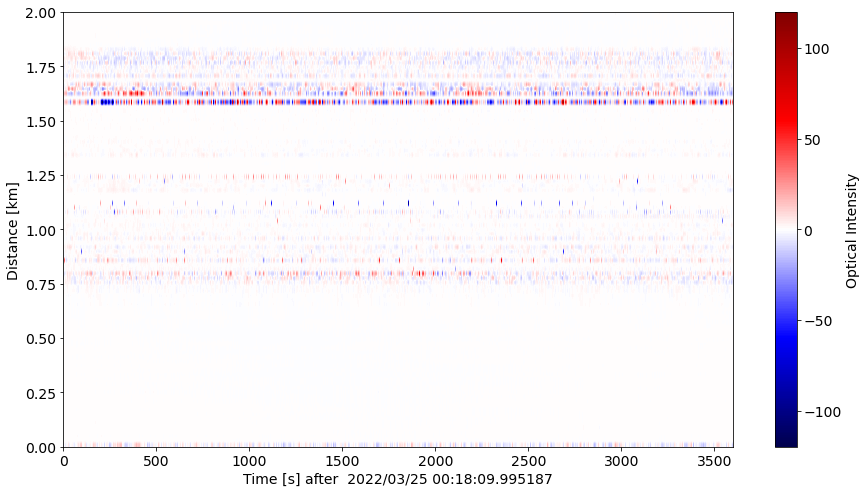

In [10]:
waterfall_plot(data,headers)